# Modeling- Part 3

Author: Harry Zhou

Contact: haininzhou@gmail.com

Date: 2023-07-15

# Introduction

Now that we are satisfied our data is ready to be put into a model, we proceed to the model building phase of our analysis. First, we need to ensure that certain assumption hold about the data: these include our samples being independent and identically distributed, and that the independent variables are not collinear or show multicollinearity. 

## Table of Contents

1.[Preprocessing data ](#1.-Preprocessing-data)
  
  - [1.1 Detecting Collinearity](#1.1-Detecting-Collinearity)
  
  - [1.2 Detecting multi collinearity](#1.2-Detecting-multi-collinearity)
  
  - [1.3 Chi Square Testing](#1.3-Chi-Square-Testing)
  
  - [1.4 Variable Selection](#1.4-Variable-Selection)
  
  - [1.5 Dealing with imbalancing](#1.5-Dealing-with-imbalancing)
  
2.[Fitting the Different Sklearn Machine Learning Classifiers](#2.-Fitting-the-Different-Sklearn-Machine-Learning-Classifiers)
  
  - [2.1 Logistic Regression](#2.1-Logistic-Regression)
   
  - [2.2 K-Nearest Neighbors](#2.2-K-Nearest-Neighbors)
   
  - [2.3 Decision Tree](#2.3-Decision-Tree)
   
  - [2.4 Support Vector Machine](#2.4-Support-Vector-Machine)
  
3.[Summary](#3.-Summary)

## 1. Preprocessing data 

In [1]:
# Importing everything we need
# The usual packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Splitting data
from sklearn.model_selection import train_test_split

# Scalers
from sklearn.preprocessing import MinMaxScaler

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import time

import warnings
warnings.filterwarnings("ignore")

To start, we read in the data.

In [2]:
df_clean = pd.read_csv("diabetes_health_indicators_BRFSS2021.csv")

df_clean.head()

,Diabetes_012,Age,Sex,Education,Income,HighBP,CholCheck,HighChol,BMI,Smoker,...,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Blind
0,0,11,0,4,5,0,1,1,1,1,...,1,1,0,1,0,5,10,20,0,0
1,2,11,0,4,3,1,1,0,3,0,...,1,0,0,1,0,2,0,0,0,0
2,2,9,0,4,7,1,1,1,4,0,...,1,1,0,1,0,2,10,0,0,0
3,0,13,1,5,6,0,1,0,2,1,...,0,0,0,1,0,3,0,0,1,0
4,0,10,0,4,8,1,1,0,4,1,...,1,1,0,1,0,3,5,25,1,0


In [3]:
#Copy old table to new one.
brfss_binary = df_clean
#Change the diabetics 2 to a 1, so that we have 0 meaning non-diabetic and pre-diabetic and 1 meaning diabetic.
brfss_binary['Diabetes_012'] = brfss_binary['Diabetes_012'].replace({2:1})

#Change the column name to Diabetes_binary
brfss_binary = brfss_binary.rename(columns = {'Diabetes_012': 'Diabetes_binary'})
brfss_binary.Diabetes_binary.unique()

array([0, 1], dtype=int64)

In [4]:
brfss_binary.sample(10)

,Diabetes_binary,Age,Sex,Education,Income,HighBP,CholCheck,HighChol,BMI,Smoker,...,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Blind
160652,0,7,0,6,10,1,1,0,1,0,...,1,1,0,1,0,3,0,0,0,0
6346,0,10,1,6,6,0,1,1,3,0,...,1,1,0,1,0,2,2,2,0,0
201646,0,9,0,5,8,0,1,1,3,1,...,1,1,0,1,0,2,2,0,0,1
10268,0,5,0,5,7,0,1,0,3,0,...,1,1,0,1,0,3,0,0,0,0
91834,0,1,1,6,9,0,1,0,3,0,...,0,1,0,1,0,1,4,0,0,0
98319,0,10,1,5,7,0,1,0,2,0,...,0,1,0,1,0,5,0,30,1,0
125403,0,1,1,5,8,0,1,0,4,0,...,1,1,0,1,1,2,25,0,0,0
18770,0,6,1,5,7,0,1,0,3,0,...,1,1,0,1,0,2,0,30,0,0
56304,0,11,1,4,5,1,1,1,3,1,...,1,1,0,1,0,5,0,6,0,0
39274,0,9,1,6,9,1,1,0,2,1,...,1,0,0,1,0,2,0,0,0,0


### 1.1 Detecting Collinearity
Collinearity can be detected by finding the pairwise correlation between the independent variables (we typically visualize this as a heatmap). If a linear/logistic regression model is to be fitted, this should always be part of the exploratory phase. If the correlation between some predictors is high, it is a sign of collinearity and we can consider including only one of those predictors in our models (or to combine the information in those predictors some way).

In [5]:
# Separate features (X) and target variable (y)
X = brfss_binary.drop('Diabetes_binary', axis=1)
y = brfss_binary['Diabetes_binary'].copy()

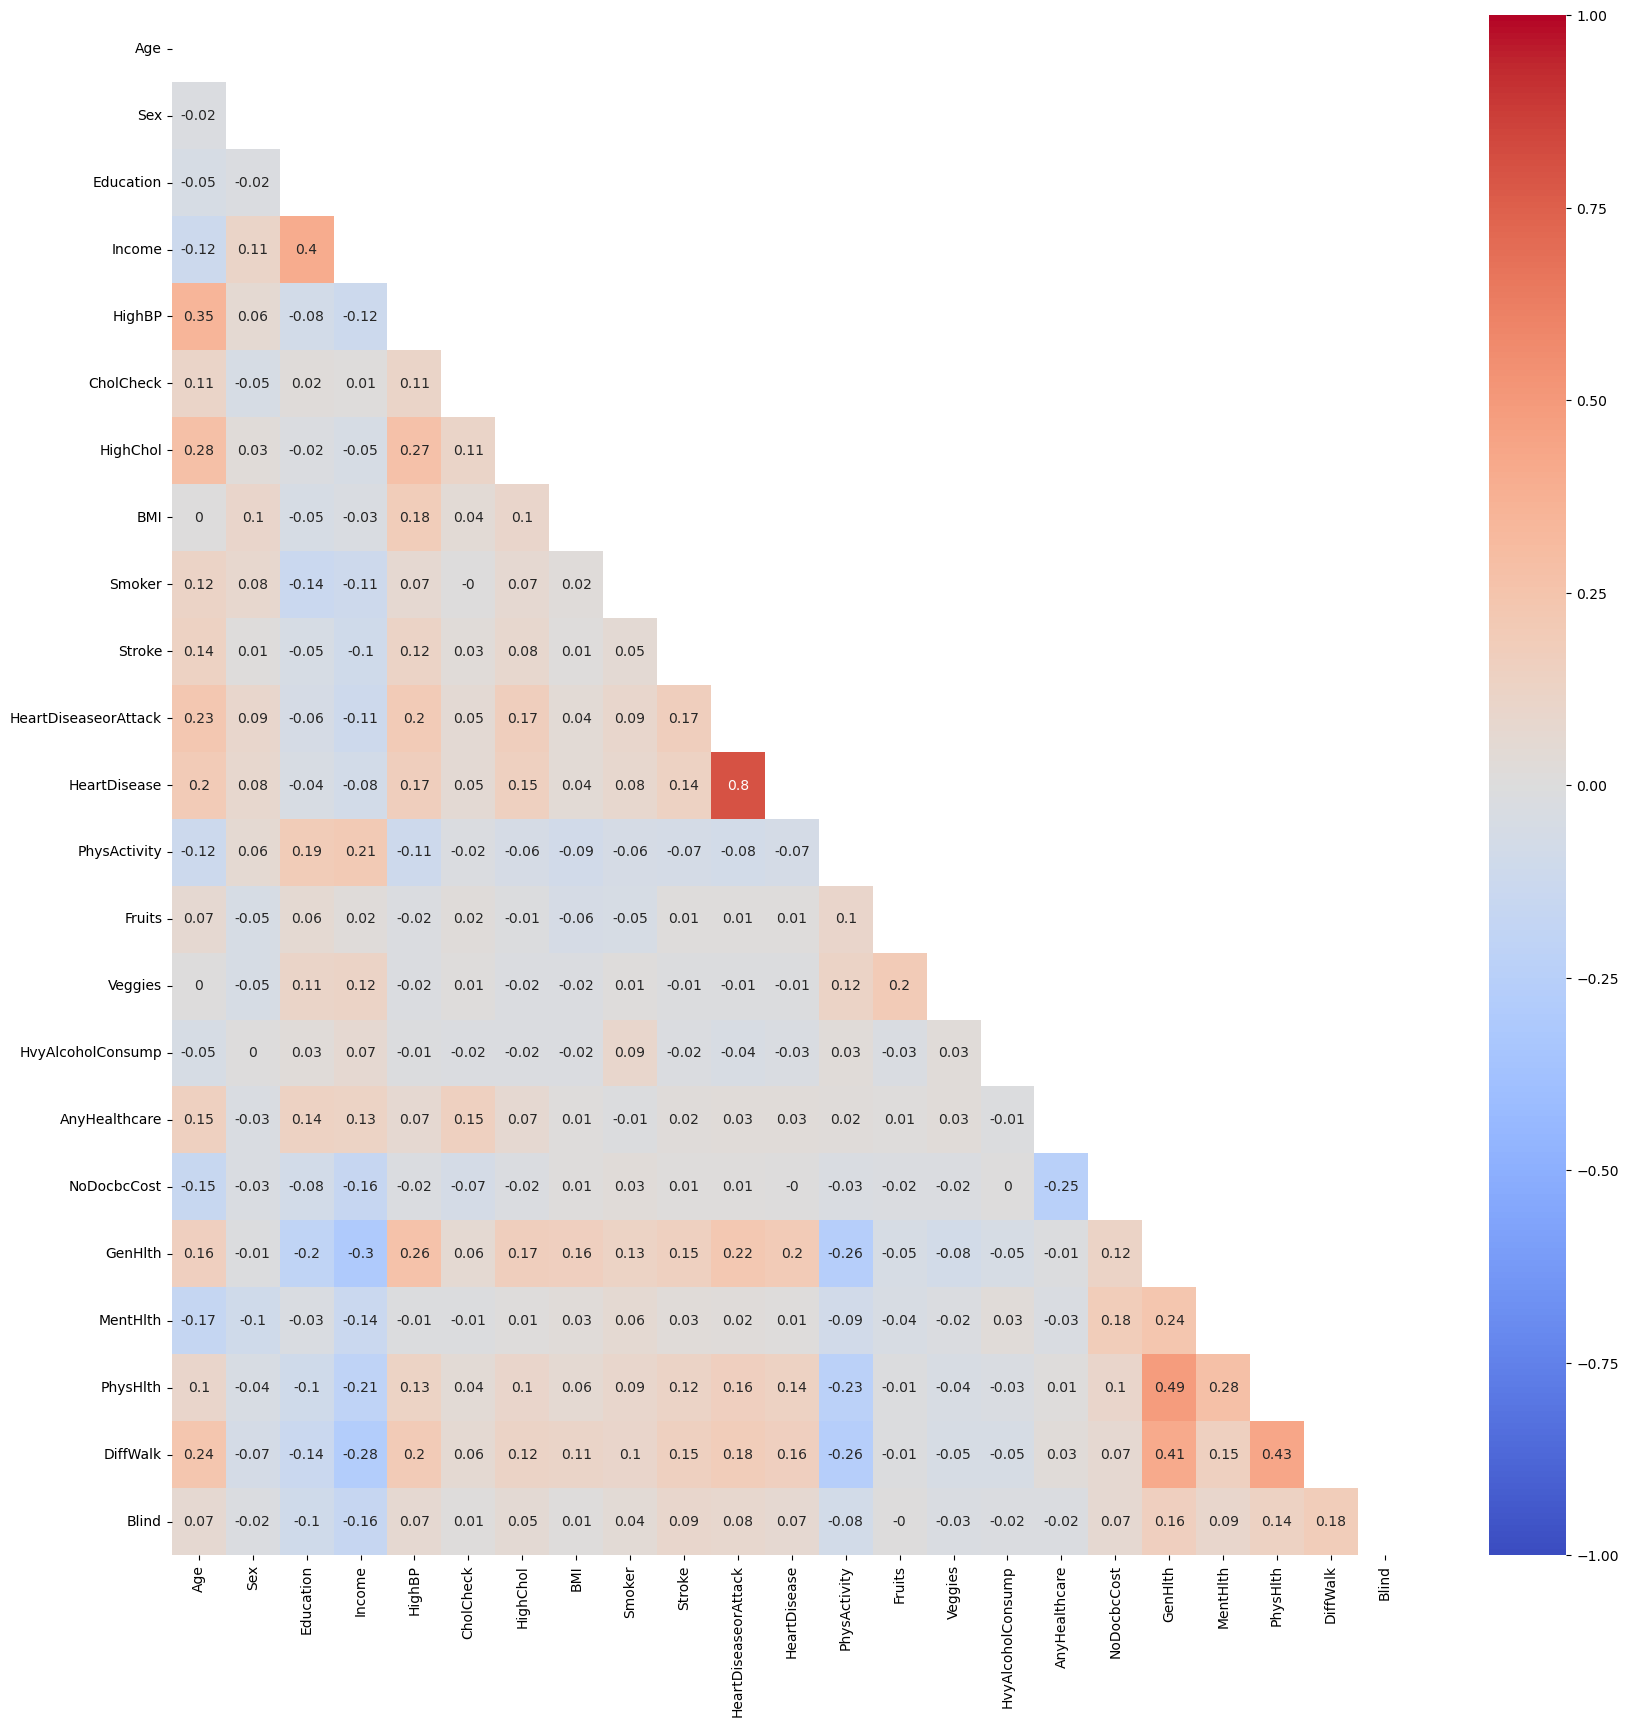

In [6]:
# Calculate all the correlations between each independent variables
corr_df = X.corr()

# Let's visulaize it

# Mask for upper-triangular
mask = np.triu(corr_df)

plt.figure(figsize=(20,20))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, cmap='coolwarm', mask=mask, center=0)
plt.show()

## Strong Correlations:

* Significant positive correlation between the HeartDiseaseorAttack and HeartDisease.

* Variables Physical Health and General Health correlated positivily

The analysis revealed a significant positive correlation between the HeartDiseaseorAttack and HeartDisease,Physical Health and General Health variables, suggesting that individuals who have experienced a heart disease or heart attack are more likely to have a pre-existing heart condition. The correlation provides evidence of the interrelationship between these two variables in terms of cardiovascular health. And General Health may be a composite measure comprising Physical Health Sum and other related factors.

* Variables Income and General Health correlated negativily

Furthermore, the analysis indicated a negative correlation between Income and General Health, implying that individuals with lower incomes may experience limited access to private medical care, potentially leading to negative impacts on their overall health outcomes.

In [7]:
X[['HeartDiseaseorAttack','HeartDisease']].describe()

,HeartDiseaseorAttack,HeartDisease
count,215258.000000,215258.000000
mean,0.096308,0.063947
std,0.295013,0.244658
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [8]:
# Drop the identified columns as colliniear

X.drop(columns=['HeartDisease'], axis=1, inplace=True)

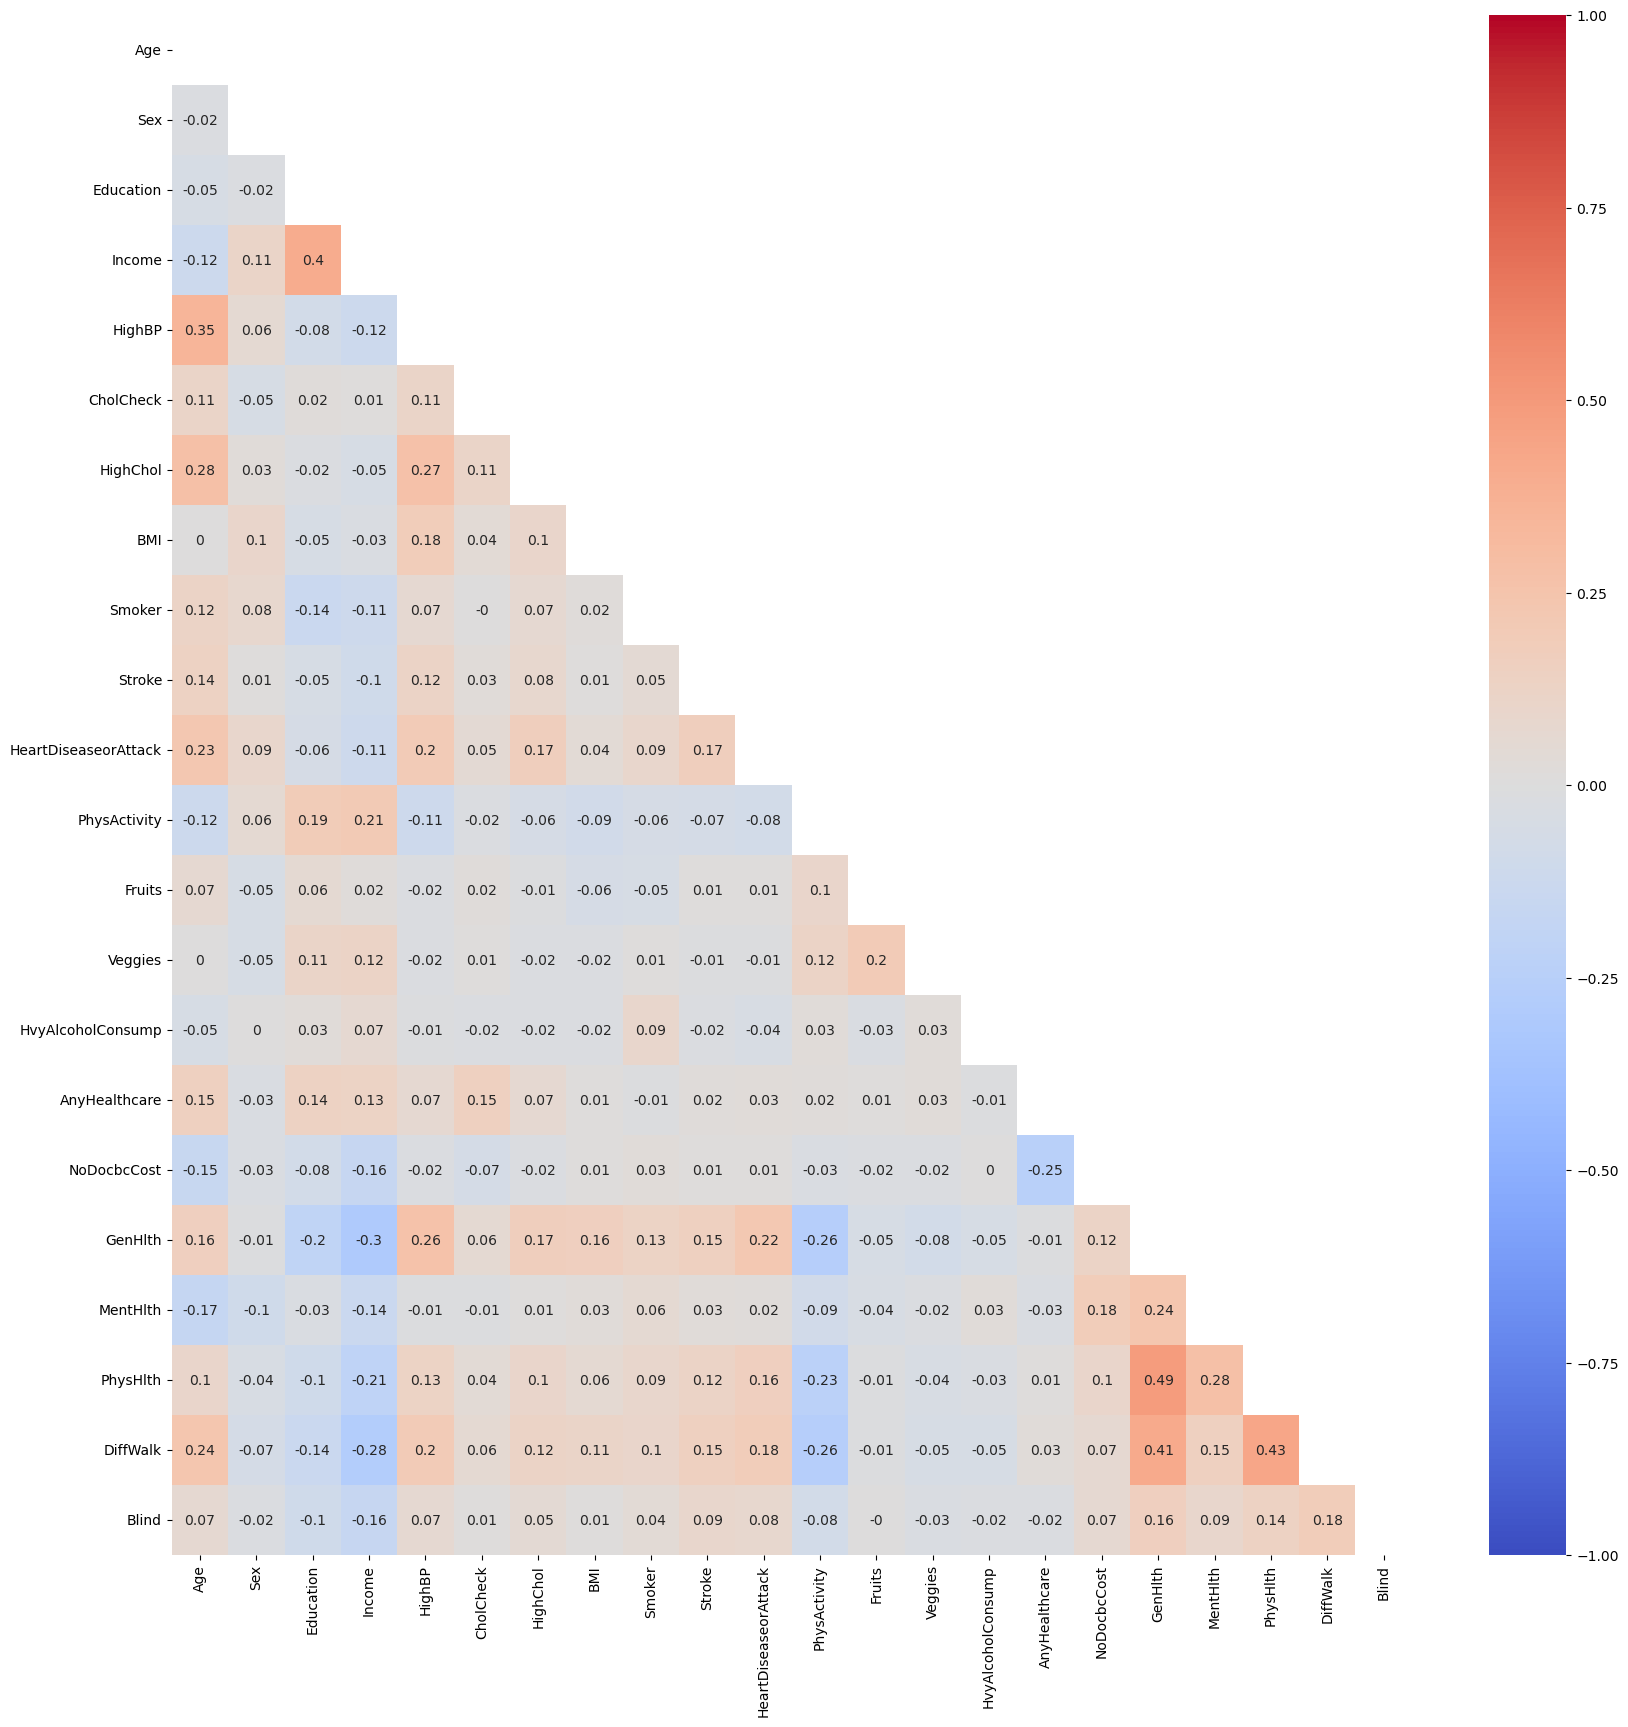

In [9]:
# Calculate all the correlations between each independent variables
corr_df = X.corr()

# Let's visulaize it

# Mask for upper-triangular
mask = np.triu(corr_df)

plt.figure(figsize=(20,20))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, cmap='coolwarm', mask=mask, center=0)
plt.show()

### 1.2 Detecting multi collinearity

#### VIF Testing

In [10]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [11]:
X_withcons = sm.add_constant(X)

In [12]:
pd.Series([variance_inflation_factor(X_withcons.values, i) for i in range(X_withcons.shape[1])], 
         index = X_withcons.columns)[1:]

Age                     1.403849
Sex                     1.081349
Education               1.256051
Income                  1.400594
HighBP                  1.279849
CholCheck               1.049513
HighChol                1.154307
BMI                     1.077871
Smoker                  1.074135
Stroke                  1.065113
HeartDiseaseorAttack    1.146181
PhysActivity            1.163964
Fruits                  1.067119
Veggies                 1.072668
HvyAlcoholConsump       1.023702
AnyHealthcare           1.132374
NoDocbcCost             1.137851
GenHlth                 1.604573
MentHlth                1.206108
PhysHlth                1.503044
DiffWalk                1.442709
Blind                   1.064370
dtype: float64

A VIF score of above 5 is an indication of multi collinearity. Since all of the VIF scores are below 5, we are good with multi collinearity.

### 1.3 Chi Square Testing

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
BestFeatures = SelectKBest(score_func=chi2, k=10)
fit = BestFeatures.fit(X,y)

df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

#concatenating two dataframes for better visualization
f_Scores = pd.concat([df_columns,df_scores],axis=1)               # feature scores
f_Scores.columns = ['Feature','Score']

f_Scores

,Feature,Score
0,Age,12583.330285
1,Sex,138.497531
2,Education,285.785997
3,Income,3438.969478
4,HighBP,8023.307858
5,CholCheck,61.592711
6,HighChol,5318.632865
7,BMI,1576.155814
8,Smoker,142.617470
9,Stroke,1726.310031


### 1.4 Variable Selection

In [14]:
print(f_Scores.nlargest(17,'Score'))

                 Feature         Score
19              PhysHlth  76362.973166
0                    Age  12583.330285
4                 HighBP   8023.307858
20              DiffWalk   6995.593070
17               GenHlth   6195.343401
6               HighChol   5318.632865
10  HeartDiseaseorAttack   4893.820825
3                 Income   3438.969478
9                 Stroke   1726.310031
7                    BMI   1576.155814
21                 Blind   1523.505386
14     HvyAlcoholConsump   1015.918156
11          PhysActivity    876.430539
18              MentHlth    857.505108
2              Education    285.785997
8                 Smoker    142.617470
1                    Sex    138.497531


We will use above 17 features in our model.

"CholCheck" , "Veggies" ,"Fruits" , " AnyHealthcare", "NoDocbcCost" will not be with us.

In [15]:
colomns = ["HeartDisease","Fruits" , "Veggies" , "CholCheck" , "AnyHealthcare" , "NoDocbcCost"]

In [16]:
brfss_binary.drop(colomns , axis= 1 ,inplace=True)

In [17]:
brfss_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215258 entries, 0 to 215257
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Diabetes_binary       215258 non-null  int64
 1   Age                   215258 non-null  int64
 2   Sex                   215258 non-null  int64
 3   Education             215258 non-null  int64
 4   Income                215258 non-null  int64
 5   HighBP                215258 non-null  int64
 6   HighChol              215258 non-null  int64
 7   BMI                   215258 non-null  int64
 8   Smoker                215258 non-null  int64
 9   Stroke                215258 non-null  int64
 10  HeartDiseaseorAttack  215258 non-null  int64
 11  PhysActivity          215258 non-null  int64
 12  HvyAlcoholConsump     215258 non-null  int64
 13  GenHlth               215258 non-null  int64
 14  MentHlth              215258 non-null  int64
 15  PhysHlth              215258 non-n

### 1.5 Dealing with imbalancing

Based on the findings from Part 2, it is evident that the dataset exhibits a significant class imbalance. Therefore, it is crucial to address this issue before proceeding with the modeling phase.

#### Data Splitting

In [18]:
X=brfss_binary.drop("Diabetes_binary",axis=1)
y=brfss_binary["Diabetes_binary"]

In [19]:
y.value_counts()

0    175326
1     39932
Name: Diabetes_binary, dtype: int64

In [20]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(version = 1 , n_neighbors = 10)

x_sm,y_sm= nm.fit_resample(X,y)

In [21]:
y_sm.shape , x_sm.shape

((79864,), (79864, 17))

In [22]:
y_sm.value_counts()

0    39932
1    39932
Name: Diabetes_binary, dtype: int64

### scaling our data

We will be fitting scaled data - using MinMaxScaler scalers - to FOUR model types:
- Logistic Regression
- K-Nearest Neighbor Classifier
- Decision Tree Classifier
- Support Vector Machine


We'll take
* Train + Validation Sets: 80%
* Test Set: 20%

In [23]:
# Taking a chuck for our 20% test set
X_remainder, X_test, y_remainder, y_test = train_test_split(x_sm,
                                                    y_sm,
                                                    test_size=0.2,
                                                    random_state=1)

# Check
print(X_remainder.shape, X_test.shape, y_remainder.shape, y_test.shape)

(63891, 17) (15973, 17) (63891,) (15973,)


Now, `X_remainder` and `y_remainder` contain the other 80%. Of remaining data, we take a 70% training set and 30% validation set.

In [24]:
# Splitting the remainder in two chunks
X_train, X_validation, y_train, y_validation = \
    train_test_split(X_remainder, y_remainder, test_size = 0.3,
                     random_state=1)

Our final proportions end up being 
* Test Set: *0.2*
* Validation Set:  0.8 * 0.3 = *0.24*
* Training Set: 0.8 * 0.7 = *0.56*

Let's check if we got the set sizes we expected.

In [25]:
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of validation set: {X_validation.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of test set: (15973, 17)
Shape of validation set: (19168, 17)
Shape of train set: (44723, 17)


This is exactly what we expected.

Now that we have our `X_train` ,`X_validation` and `X_test`, let's transform them with our scaler.

1. Instantiate the scaler
2. Fit the scaler to the **training** data
3. Transform both the training, validation and test features

**MinMaxScaler**

In [26]:
# Instantiate the scaler
MM = MinMaxScaler()

# Fit the scaler and transform both data subsets
X_train_mm = MM.fit_transform(X_train)
X_validation_mm = MM.fit_transform(X_validation)  
X_test_mm = MM.transform(X_test)

---

## 2. Fitting the Different Sklearn Machine Learning Classifiers

### 2.1 Logistic Regression

We will start with the `LogisticRegression()` and try out different C values. For this project we will be using the Ridge Regression ( `penalty="l2"` ), but we could have chosen to iterate through different C values for the Lasso Regression ( `penalty="l1"` ) as well.

Recall that **the smaller the `C`, the greater the penalization** (where the penalty is used to reduce overfitting of the model to the training data).

By trying out different C values and checking the model's accuracy scores, we are trying to find the sweet spot where we're neither too harsh nor too leniant with the penalty.

**Fitting Logistic Regression model to normalized data**

We will use a **for** loop to test each values of **C** in turn. Soon, we will learn about other functions in *scikit learn* which can make this process much more automated.

In [27]:
start = time.time()

# The C_values to try
C_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

# Empty lists to append train and test accuracy scores to
train_acc_mm = []
validation_acc_mm = []

# Loop through the different C values
for C in C_values:

    # Instantiate the model, increase max_iter to 1000
    logit = LogisticRegression(C=C, max_iter=1000, random_state=1)

    # Fit the model
    logit.fit(X_train_mm, y_train)

    # Score the model
    train_acc_mm.append(logit.score(X_train_mm, y_train))
    validation_acc_mm.append(logit.score(X_validation_mm, y_validation))

stop = time.time()
runtime_logit_mm = stop-start
print(f"Runtime: {round(runtime_logit_mm,2)} seconds")

Runtime: 2.27 seconds


Visualizing the accuracy scores for the different C values:

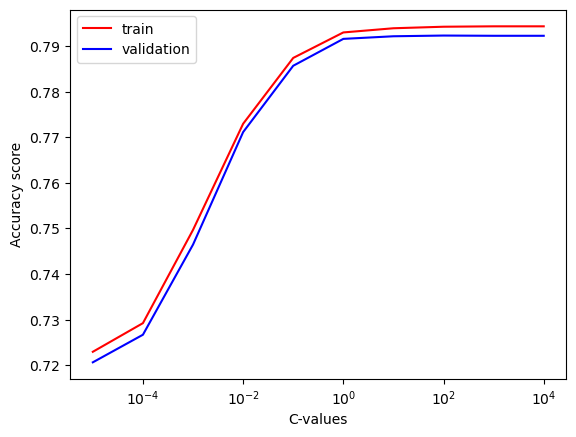

In [28]:
# visualize accuracies for different C-values
plt.figure()
plt.plot(C_values, train_acc_mm, c='red', label='train')
plt.plot(C_values, validation_acc_mm, c='blue', label='validation')
plt.xscale('log')
plt.xlabel('C-values')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()

There is justification to select `C = 1` (10<sup>0</sup>) because the plots begin to level off at this point. However, C of 10<sup>0</sup> = 1 appears to be optimal as the train and test accuracy scores were closest while still being high.

### Using the Test Set
We have decided on a "best" model. We now use the test set to get a final model evaluation. 

Again, the test set is our simulation of receiving new data our model has never seen before. We force our model to make predictions, but since we do know the true labels, we can gauge how well our model is performing. 

For our final logistic regression model with C=1, *we actually re-train the model on the collection of train and validation* data all together. We then use that model to predict on the test set.

In [29]:
# The Logistic Regression that performed the best on the standardized data
# Instantiate the model
logit_mm = LogisticRegression(C=1, random_state=1)

# Fit the model
logit_mm.fit(X_train_mm, y_train)

# Store accuracy scores
logit_mm_train = logit_mm.score(X_train_mm, y_train)
logit_mm_validation = logit_mm.score(X_validation_mm ,y_validation)
logit_mm_test = logit_mm.score(X_test_mm, y_test)

# Score the model
print(f"Train Accuracy: {logit_mm_train}")
print(f"validation Accuracy: {logit_mm_validation}")
print(f"Test Accuracy: {logit_mm_test}")

Train Accuracy: 0.7929924200076024
validation Accuracy: 0.7915797161936561
Test Accuracy: 0.7933387591560759


Finally, we got an accuracy score of 0.79 for our test data with LogisticRegression.

---

### 2.2 K-Nearest Neighbors

Let's move on to sklearn's `KNeighborsClassifier()`. We will try different `n_neighbors` for both sets of transformed data again.

Recall that n_neighbors parameter `K` is the number of nearest neighbors, when the value of `K` is too low, the model picks only the values that are closest to the data sample, thus forming a very complex decision boundary. Such a model fails to generalize well on the test data set, thereby showing poor results.

**Fitting KNN model to normalized data**

In [30]:
start = time.time()

# The different K values to try out and save to 'neighbors'
neighbors = range(1, 50, 2)

# Empty lists to append the accuracies to
train_acc_mm = []
validation_acc_mm = []

# Loop through neighbors
for K in neighbors:

    # Instantiate the model
    knn = KNeighborsClassifier(n_neighbors=K)

    # Fit the model
    knn.fit(X_train_mm, y_train)

    # Score the model
    train_acc_mm.append(knn.score(X_train_mm, y_train))
    validation_acc_mm.append(knn.score(X_validation_mm, y_validation))

stop = time.time()
runtime_knn_mm = stop-start
print(f"Runtime: {round(runtime_knn_mm,2)} seconds")

Runtime: 416.89 seconds


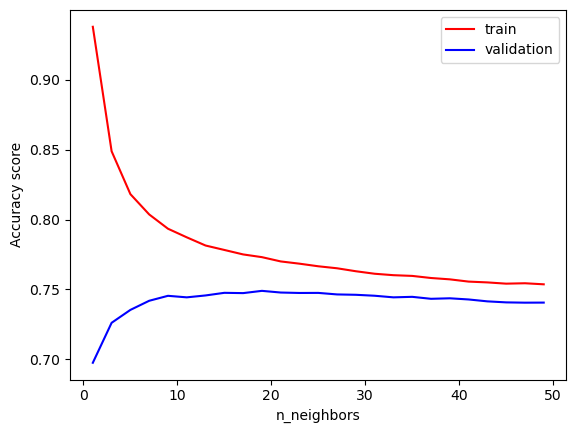

In [31]:
# Plot the accuracies
plt.figure()
plt.plot(neighbors, train_acc_mm, c='red', label='train')
plt.plot(neighbors, validation_acc_mm, c='blue', label='validation')
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()

In [32]:
# calculate the gap

best_k_index = np.argmin(np.abs((np.array(train_acc_mm) - np.array(validation_acc_mm))))
best_k = neighbors[best_k_index]

print(best_k)

41


These plots are quite choppy so conclusions will be somewhat subjective. However, the gap between the two plots is at its narrowest at around `n_neighbors = 41`.

In [42]:
# KNN that performed best on scaled data
# Instantiate the model
knn_mm = KNeighborsClassifier(n_neighbors=41)

# Fit the model
knn_mm.fit(X_train_mm, y_train)

# Store accuracy scores
knn_mm_train = knn_mm.score(X_train_mm, y_train)
knn_mm_validation = knn_mm.score(X_validation_mm ,y_validation)
knn_mm_test = knn_mm.score(X_test_mm, y_test)

# Score the model
print(f"Train Accuracy: {knn_mm_train}")
print(f"validation Accuracy: {knn_mm_validation}")
print(f"Test Accuracy: {knn_mm_test}")

Train Accuracy: 0.7556290946492856
validation Accuracy: 0.7428526711185309
Test Accuracy: 0.744068114943968


Finally, we only got an accuracy score of 0.74 for our test data with KNeighborsClassifier.

---

### 2.3 Decision Tree

Now we will fit sklearn's `DecisionTreeClassifier()` with different `max_depth` values for both sets of transformed data.

The parameter `max_depth` is what the name suggests: the maximum depth that you allow the tree to grow to. Without this, a decision tree classifier will continue until it has split every data point i.e. overfitting; the model will predict the training values but it will not perform well with unseen data.

**Fitting Decision Tree model to normalized data**

*Taking the square root of the number of rows in a sample is a reasonable starting point to inform the highest `max_depth` value to be tested.*

In [34]:
start = time.time()

# A list of the maximum depths to try out and save to 'depths'
depths = range(1, int(np.sqrt(X_train.shape[0])))

# Empty lists to append to
train_acc_mm = []
validation_acc_mm = []

# Loop through the depths
for max_depth in depths:

    # Instantiate the model
    dt = DecisionTreeClassifier(max_depth=max_depth)

    # Fit the model
    dt.fit(X_train_mm, y_train)

    # Score the model
    train_acc_mm.append(dt.score(X_train_mm, y_train))
    validation_acc_mm.append(dt.score(X_validation_mm, y_validation))

stop = time.time()
runtime_dt_mm = stop-start
print(f"Runtime: {round(runtime_dt_mm,2)} seconds")

Runtime: 61.08 seconds


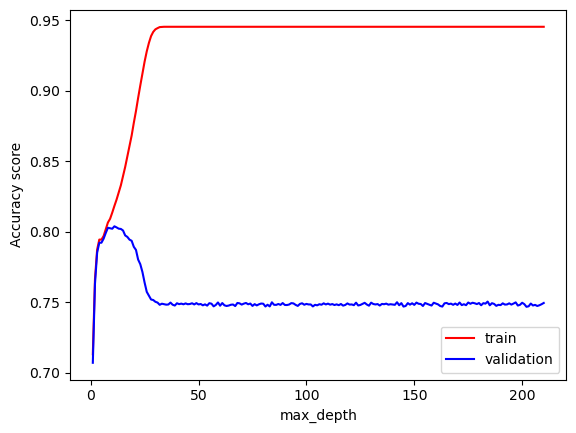

In [35]:
# Plotting the accuracies
plt.figure()
plt.plot(depths, train_acc_mm, c='red', label='train')
plt.plot(depths, validation_acc_mm, c='blue', label='validation')
plt.xlabel("max_depth")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()

Intuitively, we select `max_depth=10` as the model begins to overfit to the training data beyond this point and test accuracy is approaching its peak.

In [36]:
# Best Decision Tree Classifier on normalized data
# Instantiate the model
dt_mm = DecisionTreeClassifier(max_depth=10, random_state=1)

# Fit the model
dt_mm.fit(X_train_mm, y_train)

# Store accuracy scores
dt_mm_train = dt_mm.score(X_train_mm, y_train)
dt_mm_validation = dt_mm.score(X_validation_mm, y_validation)
dt_mm_test = dt_mm.score(X_test_mm, y_test)

# Score the model
print(f"Train Accuracy: {dt_mm_train}")
print(f"Validation Accuracy: {dt_mm_validation}")
print(f"Test Accuracy: {dt_mm_test}")

Train Accuracy: 0.8134293316637972
Validation Accuracy: 0.8020137729549248
Test Accuracy: 0.807362424090653


Finally, we got an accuracy score of 0.81 for our test data with DecisionTreeClassifier.

### 2.4 Support Vector Machine

Lastly, we will fit Support Vector Machine (SVM) models with its default kernel - radial basis function - to different `C` values.

The `C` parameter tells the SVM optimization how much you want to avoid misclassifying each training data point.

We are faced with a trade-off: increase the 'margin' (low C) to allow more data to be misclassified; decrease the margin of error (high C) to in an attempt to realize higher accuracy. The answer to this dilemma is dependent on the need for high accuracy in the particular use case.

**Fitting Support Vector Machine to normalized data**

In [37]:
start = time.time()

# Empty lists to append to
train_acc_mm = []
validation_acc_mm = []

# Looping through the C_values used earlier in Logistic Regression
for C in C_values:

    # Instantiate the model
    svm = SVC(C=C, max_iter=2000, random_state=1)

    # Fit
    svm.fit(X_train_mm, y_train)

    # Score
    train_acc_mm.append(svm.score(X_train_mm, y_train))
    validation_acc_mm.append(svm.score(X_validation_mm, y_validation))

stop = time.time()
runtime_svm_mm = stop-start
print(f"Runtime: {round(runtime_svm_mm,2)} seconds")

Runtime: 632.59 seconds


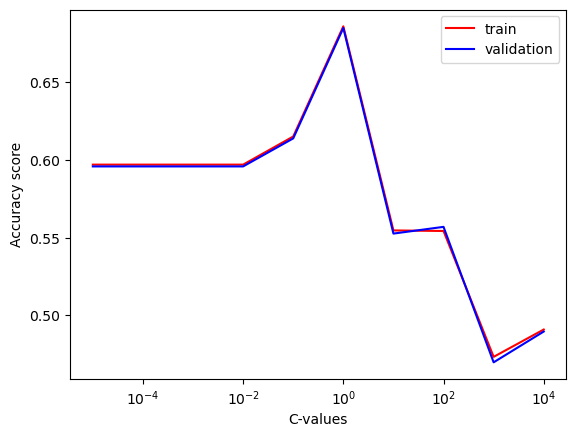

In [38]:
# Plotting the accuracies
plt.figure()
plt.plot(C_values, train_acc_mm, c='red', label='train')
plt.plot(C_values, validation_acc_mm, c='blue', label='validation')
plt.legend()
plt.xscale('log')
plt.xlabel('C-values')
plt.ylabel('Accuracy score')
plt.show()

Based on the above plots, we will select `C = 1` (10<sup>0</sup>). At `C = 1`, the increase in accuracy scores begins to slow but the 'gap' between train and test accuracy is equally narrow at `C = 1`; test accuracy also peaks at this point.

In [41]:
# Getting the SVM that best performed on the scaled data
# Instantiate the model
svm_mm = SVC(C=1, max_iter=2000, random_state=1)

# Fit the model
svm_mm.fit(X_train_mm, y_train)

# Store accuracy scores
svm_mm_train = svm_mm.score(X_train_mm, y_train)
svm_mm_validation = svm_mm.score(X_validation_mm, y_validation)
svm_mm_test = svm_mm.score(X_test_mm, y_test)

# Score the model
print(f"Train Accuracy: {svm_mm_train}")
print(f"Validation Accuracy: {svm_mm_validation}")
print(f"Test Accuracy: {svm_mm_test}")

Train Accuracy: 0.6861570109339713
Validation Accuracy: 0.6851001669449082
Test Accuracy: 0.6786452137982846


Finally, we got an accuracy score of 0.68 for our test data with SVC.

---

## 3. Summary

### Drawing our results together

In [43]:
train_mm_scores = [logit_mm_train, knn_mm_train, dt_mm_train, svm_mm_train]
validation_mm_scores = [logit_mm_validation, knn_mm_validation, dt_mm_validation, svm_mm_validation]
test_mm_scores = [logit_mm_test, knn_mm_test, dt_mm_test, svm_mm_test]
runtimes_mm = [runtime_logit_mm, runtime_knn_mm, runtime_dt_mm, runtime_svm_mm]

rows = ['Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree Classifier', 'Support Vector Machine']

model_summary = pd.DataFrame(list(zip(train_mm_scores, validation_mm_scores, test_mm_scores, runtimes_mm)),
                             index=rows,
                             columns=pd.MultiIndex.from_product([['MinMaxScaler()'],
                                                                 ['Train data', 'Validation data','Test data', 'Runtime(sec)']]))

model_summary

MinMaxScaler()                                       
                             Train data Validation data Test data Runtime(sec)
Logistic Regression            0.792992        0.791580  0.793339     2.271068
K-Nearest Neighbors            0.755629        0.742853  0.744068   416.893450
Decision Tree Classifier       0.813429        0.802014  0.807362    61.076151
Support Vector Machine         0.686157        0.685100  0.678645   632.593545

Based solely on **prediction accuracy**, the scaler/model combination which best classified the diabetes of indivaduls was...

- Fitting a `Decision Tree Classifier(max_depth=10)` model to the transformed data.

However, we should be mindful that is based purely on an assumption that maximizing accuracy is our primary aim. Next part 4, we will look at other evaluation metrics such as **Precision** and **Recall** to evaluate our models.